In [1]:
import numpy as np
from PIL import Image
from skimage import measure
from matplotlib import pyplot as plt

In [2]:
testim= np.asarray(Image.open('/media/sgr/storage/cob_tf/demo/test_segm.png'))
_=testim[:,:,0]*1000000+testim[:,:,1]*1000+testim[:,:,2]
all_labels=measure.label(_)

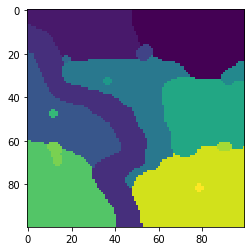

In [245]:
plt.imshow(all_labels)

In [232]:
def get_board(segmented):
    "return boarder's length" 
    from scipy.signal import correlate2d
    kernel=[[0,1,0],[1,0,1],[0,1,0]]
    outlist={}
    for idx in np.unique(segmented):    
        corr=correlate2d((segmented==idx),kernel,mode='same')
        bord=corr*(segmented!=idx)        
        outlist[idx]= [(zone,np.sum(bord[(segmented==zone) & (bord>0)])) for zone in np.unique(segmented[bord>0])]
    return outlist

In [239]:
%time get_board(all_labels)

CPU times: user 18.3 ms, sys: 45 µs, total: 18.4 ms
Wall time: 16.8 ms


{0: [(1, 21), (3, 12), (6, 27), (7, 19), (9, 15)],
 1: [(0, 21), (2, 31), (3, 9), (5, 8), (6, 32)],
 2: [(1, 31), (4, 110), (5, 4), (6, 110), (11, 38), (14, 23)],
 3: [(0, 12), (1, 9), (6, 11)],
 4: [(2, 110), (10, 16), (11, 34), (12, 11)],
 5: [(1, 8), (2, 4), (6, 4)],
 6: [(0, 27), (1, 32), (2, 110), (3, 11), (5, 4), (8, 16), (9, 53), (14, 35)],
 7: [(0, 19), (9, 16)],
 8: [(6, 16)],
 9: [(0, 15), (6, 53), (7, 16), (13, 12), (14, 34)],
 10: [(4, 16)],
 11: [(2, 38), (4, 34), (12, 27)],
 12: [(4, 11), (11, 27)],
 13: [(9, 12), (14, 10)],
 14: [(2, 23), (6, 35), (9, 34), (13, 10), (15, 16)],
 15: [(14, 16)]}

In [247]:
jj= get_board(all_labels)
outdict={}
for key in jj:
    for kk, lent in jj[key]:
        if kk>key:
            outdict[(key, kk)]=lent

In [248]:
outdict

{(0, 1): 21,
 (0, 3): 12,
 (0, 6): 27,
 (0, 7): 19,
 (0, 9): 15,
 (1, 2): 31,
 (1, 3): 9,
 (1, 5): 8,
 (1, 6): 32,
 (2, 4): 110,
 (2, 5): 4,
 (2, 6): 110,
 (2, 11): 38,
 (2, 14): 23,
 (3, 6): 11,
 (4, 10): 16,
 (4, 11): 34,
 (4, 12): 11,
 (5, 6): 4,
 (6, 8): 16,
 (6, 9): 53,
 (6, 14): 35,
 (7, 9): 16,
 (9, 13): 12,
 (9, 14): 34,
 (11, 12): 27,
 (13, 14): 10,
 (14, 15): 16}

In [240]:
def clear_segment_map(segment_map, image, area_thresh=5):
    '''
    segment_map - indexed connected pixels groups where 0 - labeling masked area
    '''
    from skimage import measure
    from scipy import ndimage
    import pandas as pd    
    h,w,d=image.shape    
    index, reg_area = np.unique(segment_map,return_counts=True)    
    
    coord_lists=[(segment_map.ravel()==ind).nonzero()[0] for ind in index] 
    
    region_means=[np.array(i) for i in zip(*[ndimage.mean(image[:,:,band], labels=segment_map, index=index) for band in range(d)])]    
    return pd.DataFrame({'index':index, 'area':reg_area, 'pixels':coord_lists, 'features':region_means})   
#     return {'index':index, 'area':reg_area, 'pixels':coord_lists, 'features':region_means}  

In [246]:
hhh=clear_segment_map(all_labels, testim)
hhh[hhh['area']<100]

,index,area,pixels,features
3,3,46,"[1653, 1654, 1655, 1752, 1753, 1754, 1755, 175...","[49.0, 150.0, 32.0]"
5,5,12,"[2117, 2118, 2216, 2217, 2218, 2219, 2316, 231...","[72.0, 69.0, 17.0]"
7,7,81,"[2497, 2498, 2499, 2596, 2597, 2598, 2599, 269...","[49.0, 150.0, 32.0]"
8,8,12,"[3136, 3137, 3235, 3236, 3237, 3238, 3335, 333...","[72.0, 69.0, 17.0]"
10,10,12,"[4611, 4612, 4710, 4711, 4712, 4713, 4810, 481...","[49.0, 150.0, 32.0]"
12,12,51,"[6110, 6111, 6112, 6113, 6209, 6210, 6211, 621...","[49.0, 150.0, 32.0]"
13,13,24,"[6188, 6189, 6190, 6191, 6192, 6287, 6288, 628...","[72.0, 69.0, 17.0]"
15,15,12,"[8078, 8079, 8177, 8178, 8179, 8180, 8277, 827...","[72.0, 69.0, 17.0]"
